In [ ]:
#!wget https://hktn2022.blob.core.windows.net/dataset/hist_data.csv

In [ ]:
#!wget https://hktn2022.blob.core.windows.net/dataset/test.csv

In [ ]:
import pandas as pd
import numpy as np
import gc
from collections import Counter 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# Бейзлайн

In [ ]:
# Пример решения с использованием статистического подхода - подсчет 
# совстречаемостей.

import pandas as pd
import numpy as np
import gc

from collections import Counter 

hist_data = pd.read_csv('/content/drive/MyDrive/hack-the-cart/hist_data.csv')

# соберем словарь встречаемостей - какие item_id покупались чаще с 
# каждым item_id 
tmp = (
    hist_data[['item_id', 'pav_order_id']]
    .sort_values(['item_id', 'pav_order_id'])
    .merge(hist_data[['item_id', 'pav_order_id']], how='left', on=['pav_order_id'], suffixes=('', '_left'))
)
tmp = tmp[tmp['item_id'] != tmp['item_id_left']].copy()
tmp1 = tmp.groupby(['item_id'])['item_id_left'].agg(lambda x: Counter(x).most_common(10))

most_freq_dict = {k: v for (k, v) in tmp1.iteritems()}

del tmp1, tmp
gc.collect()

test = pd.read_csv('/content/drive/MyDrive/hack-the-cart/test.csv')

# из списка кандидатов по совстречаемости удаляем повторяющиеся item_id, 
# сохраняя порядок
def get_unique_recs(recs: list, top_n: int) -> list:
    rec_dict = {}
    counter = 0
    for k, v in recs:
        if k not in rec_dict:
            rec_dict[k] = v
            counter += 1
        if counter == top_n:
            break
    return list(rec_dict.keys())

def rec_by_item(item_id: int, most_freq_dict: dict) -> list:
    
    return most_freq_dict.get(item_id, None)

# для каждого item_id соберем top_n самых часто встречающихся item_id, 
# отсортируем по частоте и выберем уникальные
def rec_by_basket(basket: list, most_freq_dict: dict, top_n: int = 20) -> list:
    
    res = []
    for item in basket:
        recs = rec_by_item(item, most_freq_dict)
        if recs is not None:
            res += recs
    
    res = sorted(res, key=lambda x: x[1], reverse=True)
    
    return get_unique_recs(res, top_n)

pred = test.groupby(['pav_order_id'])['item_id'].agg([('basket', list)])
pred['preds'] = pred['basket'].map(lambda x: rec_by_basket(x, most_freq_dict=most_freq_dict))

pred['preds'].to_csv('pred.csv')

In [ ]:
# Пример использования подхода из бейзлайна для тестирования модели и 
# расчета метрики через деление hist_data на трейн и валидацию

import gc
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

def split_data(data, test_size=0.3):
    orders_sort = data[['pav_order_id', 'created']].drop_duplicates().sort_values(by=['created', 'pav_order_id'])
    train_orders, test_orders = train_test_split(orders_sort['pav_order_id'].tolist(), test_size=test_size, shuffle=False)
    train_orders, test_orders = set(train_orders), set(test_orders)
    train = data[data['pav_order_id'].apply(lambda x: x in train_orders)]
    test = data[data['pav_order_id'].apply(lambda x: x in test_orders)]
    return train, test, orders_sort, train_orders, test_orders

# из списка кандидатов по совстречаемости удаляем повторяющиеся item_id, сохраняя порядок
def get_unique_recs(recs: list, top_n: int) -> list:
    rec_dict = {}
    counter = 0
    for k, v in recs:
        if k not in rec_dict:
            rec_dict[k] = v
            counter += 1
        if counter == top_n:
            break
    return list(rec_dict.keys())

def rec_by_item(item_id: int, most_freq_dict: dict) -> list:
    
    return most_freq_dict.get(item_id, None)

# для каждого item_id соберем top_n самых часто встречающихся item_id, отсортируем по частоте и выберем уникальные
def rec_by_basket(basket: list, most_freq_dict: dict, top_n: int = 20) -> list:
    
    res = []
    for item in basket:
        recs = rec_by_item(item, most_freq_dict)
        if recs is not None:
            res += recs
    
    res = sorted(res, key=lambda x: x[1], reverse=True)
    
    return get_unique_recs(res, top_n)

# метрики оцениваются для вектора релевантности. пример:
# реальные item_id, которые приобрел покупатель: [1 ,4, 5, 69]
# рекомендованные алгоритмом item_id: [4, 6, 7, 8, 1, 2, 67, 90]
# тогда вектор релеватности будет выглядеть следующим образом: [1, 0, 0, 0, 1, 0, 0, 0]
# и уже по не му будет расчитываться ndcg
def dcg(
    y_relevance: np.ndarray
) -> float:
    return np.sum([(2**i - 1) / np.log2(k + 1) for (k, i) in enumerate(y_relevance, start=1)])

def ndcg(
    y_relevance: np.ndarray,
    k: int
) -> float:
    if y_relevance.sum() == 0:
        return 0.0
    DCG = dcg(y_relevance[:k])
    IDCG = dcg(-np.sort(-y_relevance)[:k])
    return DCG / IDCG

def apply_relevance(x):
    return [int(item in x['basket']) for item in x['preds']]

def create_relevance(pred):
    d = pred.copy()
    d['basket'] = d['basket'].apply(set)
    d = d.apply(apply_relevance, axis=1)
    return d

def ndcg_full_dataset(d):
    dd = pd.DataFrame(d.to_list()).fillna(0).to_numpy()
    k = dd.shape[1]
    scores = [ndcg(dd[i], k) for i in range(len(dd))]
    return np.mean(scores)

def compute_ndcg_score(pred):
    relevance = create_relevance(pred)
    return ndcg_full_dataset(relevance)

def make_coocurs_dict(train_data):
    tmp = (
        train_data[['item_id', 'pav_order_id']]
        .sort_values(['item_id', 'pav_order_id'])
        .merge(train_data[['item_id', 'pav_order_id']], how='left', on=['pav_order_id'], suffixes=('', '_left'))
    )
    tmp = tmp[tmp['item_id'] != tmp['item_id_left']].copy()
    tmp1 = tmp.groupby(['item_id'])['item_id_left'].agg(lambda x: Counter(x).most_common(10))

    most_freq_dict = {k: v for (k, v) in tmp1.iteritems()}

    del tmp1, tmp
    gc.collect()
    return most_freq_dict

def create_basket(test_data):
    pred = test_data.groupby(['pav_order_id'])['item_id'].agg([('basket', list)])
    return pred

def make_predictions(test_data, most_freq_dict):
    pred = create_basket(test_data)
    pred['preds'] = pred['basket'].map(lambda x: rec_by_basket(x, most_freq_dict=most_freq_dict))
    return pred


# считываем исторические данные
data = pd.read_csv("/content/drive/MyDrive/hack-the-cart/hist_data.csv", parse_dates=['created'])

# разобьем историю в отношении 70 на 30 для трейна и валидации
train_data, test_data, orders_sort, train_orders, test_orders = split_data(data)

# соберем словарь встречаемостей - какие item_id покупались чаще с каждым item_id 
most_freq_dict = make_coocurs_dict(train_data)
# предсказываем
pred = make_predictions(test_data, most_freq_dict)
pred.to_csv("preds_on_splitted_hist_data.csv")

# посчитаем скор для всего набора предсказаний
d_score = compute_ndcg_score(pred)
print(d_score)

0.34481132996828945


In [ ]:
test.sort_values(['created'])

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods
185923,95077787,98506637928,2021-07-01 00:05:03,202862432,1.00,59.990,True
445567,95077787,98506637928,2021-07-01 00:05:03,202826903,1.00,29.995,True
865447,95077787,98506637928,2021-07-01 00:05:03,203101328,1.00,127.990,False
528322,95077787,98506637928,2021-07-01 00:05:03,204116363,0.25,62.498,True
756775,95077787,98506637928,2021-07-01 00:05:03,202880254,0.50,43.495,True
...,...,...,...,...,...,...,...
920407,96405523,98521278926,2021-09-07 21:05:23,203043470,1.00,39.990,False
659746,96405523,98521278926,2021-09-07 21:05:23,204045044,1.00,96.990,False
1053782,96405523,98521278926,2021-09-07 21:05:23,204123143,1.00,79.000,False
635323,96405523,98521278926,2021-09-07 21:05:23,202906593,1.00,59.990,False


# EDA
Просмотр статистик

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
hist_data = pd.read_csv('/content/drive/MyDrive/hack-the-cart/hist_data.csv')
test = pd.read_csv('/content/drive/MyDrive/hack-the-cart/test.csv')


In [ ]:
item_list = test["item_id"].unique().tolist()
item_list.extend(hist_data["item_id"].unique().tolist())

In [ ]:
def make_format_time(user_data):
    user_data["created"] = pd.to_datetime(user_data["created"], format="%Y%m%d %H")
    user_data["date"] = user_data["created"].dt.date
    user_data["weekday"] = user_data["created"].dt.weekday
    user_data["hour"] = user_data["created"].dt.hour
    return user_data

In [ ]:
hist_data = make_format_time(hist_data)
test = make_format_time(test)

In [ ]:
def erveryday_buy_counts(user_data,in_itemlist=False):
    if in_itemlist == True:
        condition = user_data["item_id"].isin(item_list)
    else:
        condition = True
    item_day_buy_count = user_data[condition][["buyer_id", "item_id", "date"]].drop_duplicates()
    item_day_buy_count["buy_count"] = 1
    item_day_buy_count["date"] = item_day_buy_count["date"].apply(lambda x : str(x)[5:]) # 日期只显示月日
    item_day_buy_count = item_day_buy_count[["date", "buy_count"]].groupby("date", as_index=False).count().sort_values(by="date")
    # 绘制柱状图
    f, ax = plt.subplots(figsize=(35, 5))
    fig = sns.barplot(x=item_day_buy_count["date"], y=item_day_buy_count["buy_count"])

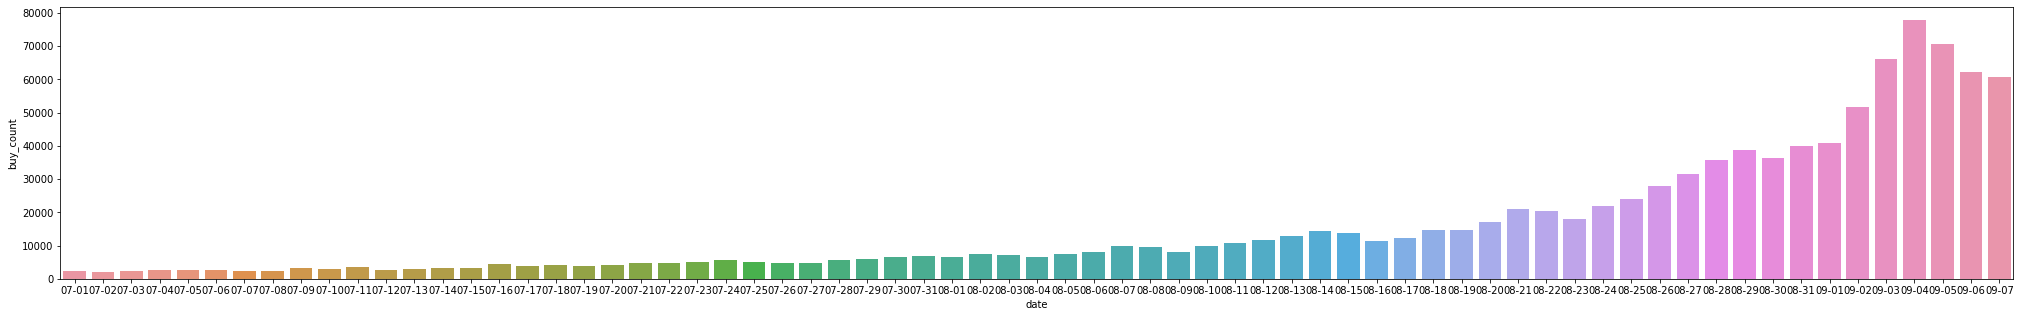

In [ ]:
erveryday_buy_counts(test,in_itemlist=True)
# Распределение по тестовой выборке

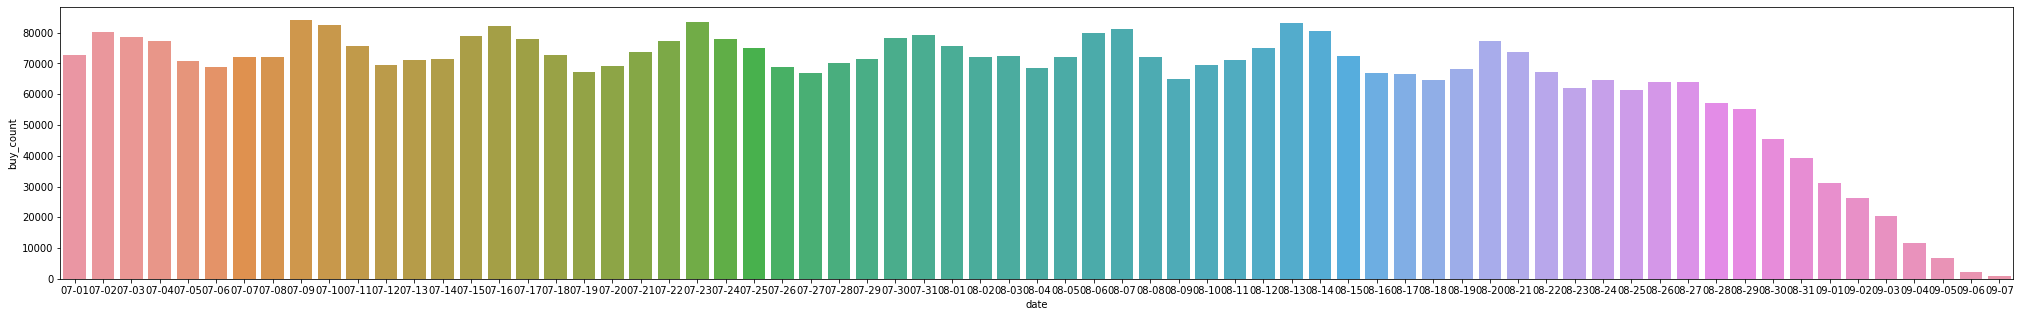

In [ ]:
erveryday_buy_counts(hist_data,in_itemlist=True)
# Распределение по тренировочной выборке

In [ ]:
len(test)

1081420

In [ ]:
len(pd.unique(test['pav_order_id']))

80244

In [ ]:
test

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,date,weekday,hour
0,94640077,98519243164,2021-08-30 17:56:31,203053459,1.00,67.62,False,2021-08-30,0,17
1,95865222,98512083628,2021-07-26 16:17:21,202967705,1.14,406.80,True,2021-07-26,0,16
2,95147155,98519972197,2021-09-02 21:54:18,203551512,1.00,52.77,False,2021-09-02,3,21
3,94832207,98518646272,2021-08-28 10:43:23,202801712,1.00,92.89,False,2021-08-28,5,10
4,95483101,98510857920,2021-07-20 14:27:08,203416702,2.00,238.99,False,2021-07-20,1,14
...,...,...,...,...,...,...,...,...,...,...
1081415,95178159,98519703380,2021-09-01 19:10:29,203240557,1.00,69.99,False,2021-09-01,2,19
1081416,95597512,98519797071,2021-09-02 10:29:11,202806932,1.00,44.99,False,2021-09-02,3,10
1081417,95553515,98520350679,2021-09-04 11:33:18,205755780,3.00,44.89,False,2021-09-04,5,11
1081418,95688424,98509396234,2021-07-13 14:41:37,203423005,1.00,46.74,False,2021-07-13,1,14


In [ ]:
hist_data

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight,date,weekday,hour
0,95203091,98506637863,2021-07-01 00:03:44,202808329,1.000,79.990,False,11.14,2021-07-01,3,0
1,95203091,98506637863,2021-07-01 00:03:44,202953905,1.072,44.945,True,11.14,2021-07-01,3,0
2,95203091,98506637863,2021-07-01 00:03:44,203566452,1.000,69.990,False,11.14,2021-07-01,3,0
3,95203091,98506637863,2021-07-01 00:03:44,202820143,1.972,41.295,True,11.14,2021-07-01,3,0
4,95203091,98506637863,2021-07-01 00:03:44,204400422,1.000,269.990,False,11.14,2021-07-01,3,0
...,...,...,...,...,...,...,...,...,...,...,...
4529884,95619205,4620221347,2021-09-07 18:48:29,204351817,1.000,99.990,False,9.84,2021-09-07,1,18
4529885,95619205,4620221347,2021-09-07 18:48:29,203523604,1.000,62.190,False,9.84,2021-09-07,1,18
4529886,95619205,4620221347,2021-09-07 18:48:29,203566357,2.000,39.890,False,9.84,2021-09-07,1,18
4529887,95619205,4620221347,2021-09-07 18:48:29,203566418,1.000,62.190,False,9.84,2021-09-07,1,18


In [ ]:
len(pd.unique(hist_data['pav_order_id']))

231339

In [ ]:
pred = pd.read_csv('pred.csv')


In [ ]:
len(pred)

80244

In [ ]:
hist_data

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight,date,weekday,hour
0,95203091,98506637863,2021-07-01 00:03:44,202808329,1.000,79.990,False,11.14,2021-07-01,3,0
1,95203091,98506637863,2021-07-01 00:03:44,202953905,1.072,44.945,True,11.14,2021-07-01,3,0
2,95203091,98506637863,2021-07-01 00:03:44,203566452,1.000,69.990,False,11.14,2021-07-01,3,0
3,95203091,98506637863,2021-07-01 00:03:44,202820143,1.972,41.295,True,11.14,2021-07-01,3,0
4,95203091,98506637863,2021-07-01 00:03:44,204400422,1.000,269.990,False,11.14,2021-07-01,3,0
...,...,...,...,...,...,...,...,...,...,...,...
4529884,95619205,4620221347,2021-09-07 18:48:29,204351817,1.000,99.990,False,9.84,2021-09-07,1,18
4529885,95619205,4620221347,2021-09-07 18:48:29,203523604,1.000,62.190,False,9.84,2021-09-07,1,18
4529886,95619205,4620221347,2021-09-07 18:48:29,203566357,2.000,39.890,False,9.84,2021-09-07,1,18
4529887,95619205,4620221347,2021-09-07 18:48:29,203566418,1.000,62.190,False,9.84,2021-09-07,1,18


Распределение по размеру корзины

In [ ]:
order_count = hist_data[["pav_order_id","count"]]
order_count = order_count[["pav_order_id", "count"]].groupby("pav_order_id", as_index=False)['count'].sum()
order_count.sort_values(['count'])

,pav_order_id,count
151085,98514531194,3.302
211226,98518122862,4.401
147783,98514351303,4.624
39640,98508564133,4.982
10744,98506842724,5.242
...,...,...
40268,98508598969,498.000
197520,98517158805,615.638
195112,98517018184,622.000
166771,98515391218,657.000


In [ ]:
order_count["count"].mode()

0    18.0
dtype: float64

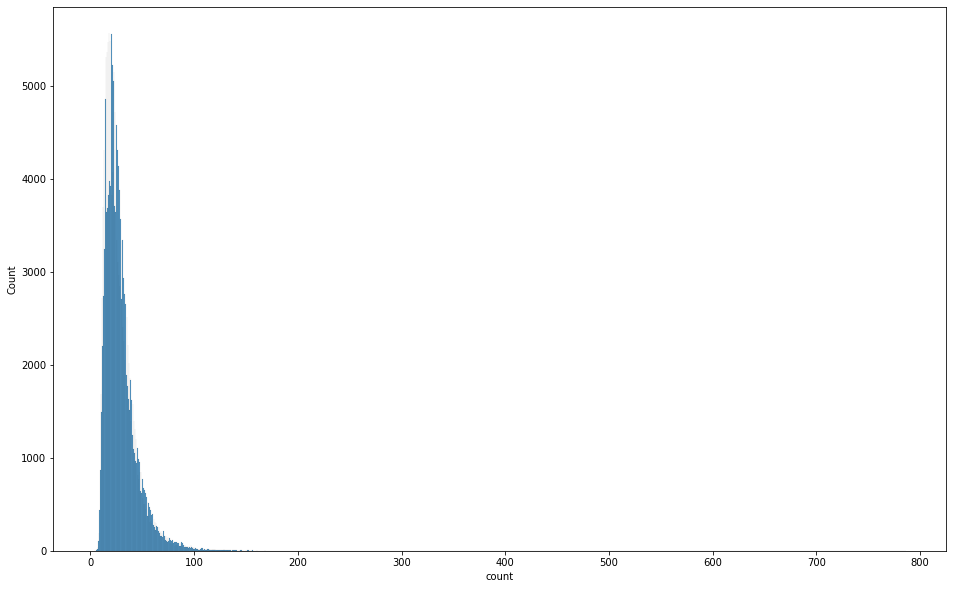

In [ ]:
#  fig = sns.histplot(x=order_count["pav_order_id"], y=order_count["count"])
plt.figure(figsize=(16, 10))
sns.histplot(order_count["count"])
plt.show()

In [ ]:
hist_buyers = set(hist_data['buyer_id'])
hist_buyers, len(hist_buyers)

({95289347,
  95551497,
  94765066,
  96075788,
  94765072,
  95682577,
  95158290,
  95289363,
  95420436,
  95027219,
  95551510,
  94634007,
  96206875,
  95158302,
  94765091,
  95551524,
  94896166,
  95027239,
  95027242,
  95682603,
  95551532,
  95027244,
  96206894,
  95289391,
  94765106,
  95289395,
  95551538,
  96206901,
  95289398,
  95158325,
  94896184,
  94765115,
  96206909,
  94896193,
  95551554,
  94634051,
  95289411,
  95420485,
  95158344,
  94634057,
  95158345,
  95027275,
  95158348,
  95682633,
  95682641,
  95551570,
  94765137,
  95027285,
  94896218,
  95813724,
  96338012,
  94634081,
  95158373,
  94634089,
  94765162,
  95551596,
  95289452,
  95027310,
  95289457,
  95420530,
  94634097,
  95027313,
  96206961,
  94896248,
  95027321,
  95158396,
  95420543,
  95289475,
  95027332,
  94765189,
  95027334,
  95813766,
  95027337,
  94765193,
  94896267,
  94896268,
  94634122,
  95158411,
  95420559,
  95027345,
  96075922,
  95813779,
  95944850,
  95

In [ ]:
test_buyers = set(test['buyer_id'])
test_buyers, len(test)

({95420416,
  94633991,
  94896139,
  95682577,
  95158290,
  95420436,
  94634007,
  96206875,
  94896158,
  95158302,
  94896166,
  95682603,
  96206894,
  96206901,
  95158325,
  95420472,
  94896184,
  95944763,
  96206909,
  96206910,
  94896193,
  94634051,
  95420485,
  95158344,
  94634057,
  95158345,
  95682633,
  95158348,
  95682641,
  94896218,
  94634079,
  94634081,
  95158373,
  94634089,
  94634097,
  95420530,
  96206961,
  94896248,
  95158396,
  95420543,
  95158404,
  94634119,
  96206985,
  94634122,
  94896267,
  95158411,
  94896268,
  95420559,
  95944850,
  95944853,
  95158428,
  95944861,
  94896285,
  94634144,
  96207015,
  94634153,
  95682729,
  95420594,
  94634162,
  94896310,
  94634168,
  95420601,
  96207037,
  95682754,
  95420612,
  95682759,
  95682760,
  95420616,
  94634191,
  94896338,
  95158484,
  95944922,
  95158493,
  95158496,
  94896355,
  95420644,
  94634215,
  94634217,
  95158506,
  95420651,
  94634220,
  95158508,
  95158511,
  96

In [ ]:
new_bayers = test_buyers - hist_buyers

# Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from functools import reduce
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
# User related feature extraction function
# The total number of times the user performs each type of operation
def user_action_total_counts(data):
    data["user_action_total_counts"] = 1
    feature = data[["buyer_id", "user_action_total_counts"]].groupby(["buyer_id"], as_index=False).count()
    return feature

# Commodity-related feature extraction function
# The total number of times each type of operation is performed on the product
def item_action_total_counts(data):
    data["item_action_total_counts"] = 1
    feature = data[["item_id", "item_action_total_counts"]].groupby(["item_id"], as_index=False).count()
    return feature
# The total number of users who perform various types of operations on the product
def item_total_user_counts(data):
    data = data[["buyer_id", "item_id"]].drop_duplicates()
    data["item_total_user_counts"] = 1
    feature = data[["item_id", "item_total_user_counts"]].groupby(["item_id"], as_index=False).count()
    return feature

# Commodity type related feature extraction function
# The total number of times that this type of product has been executed with each type of operation
#weight category
def category_action_total_counts(data):
    data["category_action_total_counts"] = 1
    feature = data[["flag_weight_goods", "category_action_total_counts"]].groupby(["flag_weight_goods"], as_index=False).count()
    return feature
# The total number of users who have performed various types of operations on this type of product
def category_total_user_counts(data):
    data = data[["buyer_id", "item_category"]].drop_duplicates()
    data["category_total_user_counts"] = 1
    feature = data[["flag_weight_goods", "category_total_user_counts"]].groupby(["flag_weight_goods"], as_index=False).count()
    return feature

# User-item related feature extraction function
# The total number of times the user performs various types of operations on the product
def user_item_action_total_counts(data):
    data["user_item_action_total_counts"] = 1
    feature = data[["buyer_id", "item_id", "user_item_action_total_counts"]].groupby(["buyer_id", "item_id"], as_index=False).count()
    return feature

# User-commodity type related feature extraction function
# The total number of times the user performs various type operations on the same type of product
def user_category_action_total_counts(data):
    data["user_category_action_total_counts"] = 1
    feature = data[["buyer_id", "flag_weight_goods", "user_category_action_total_counts"]].groupby(["buyer_id", "flag_weight_goods"], as_index=False).count()
    return feature

In [ ]:

# 构造特征函数 predict_date:预测日期
def get_feature(predict_date):
    train_data = hist_data[hist_data["time"] < predict_date]
#     # 用户相关特征
#     # u1:用户执行各项type操作的总次数
#     u1 = user_action_total_counts(train_data)
#     # u2:用户浏览商品的次数
#     u2 = user_type_counts(train_data, 1, "user_look_counts")
#     # u3:用户收藏商品的次数
#     u3 = user_type_counts(train_data, 2, "user_like_counts")
#     # u4:用户加入购物车的次数
#     u4 = user_type_counts(train_data, 3, "user_add_counts")
#     # u5:用户购买商品的次数
#     u5 = user_type_counts(train_data, 4, "user_buy_counts")
    
#     # 商品相关特征
#     # i1:商品被执行各项type操作的总次数
#     i1 = item_action_total_counts(train_data)
#     # i2:对商品执行各项type操作的用户总数
#     i2 = item_total_user_counts(train_data)
#     # i3:商品被浏览的次数
#     i3 = item_type_counts(train_data, 1, "item_look_counts")
#     # i4:商品被收藏的次数
#     i4 = item_type_counts(train_data, 2, "item_like_counts")
#     # i5:商品被加入购物车的次数
#     i5 = item_type_counts(train_data, 3, "item_add_counts")
#     # i6:商品被购买的次数
#     i6 = item_type_counts(train_data, 4, "item_buy_counts")
    
#     # 商品类型特征
#     # c1:商品被执行各项type操作的总次数
#     c1 = category_action_total_counts(train_data)
#     # c2:对商品执行各项type操作的用户总数
#     c2 = category_total_user_counts(train_data)
#     # c3:此类型商品被浏览的次数
#     c3 = category_type_counts(train_data, 1, "category_look_counts")
#     # c4:此类型商品被收藏的次数
#     c4 = category_type_counts(train_data, 2, "category_like_counts")
#     # c5:此类型商品被加入购物车的次数
#     c5 = category_type_counts(train_data, 3, "category_add_counts")
#     # c6:此类型商品被购买的次数
#     c6 = category_type_counts(train_data, 4, "category_buy_counts")
    
    # 用户-商品相关特征
    # ui1:用户对商品执行各项type操作的总次数
#     ui1 = user_item_action_total_counts(train_data)
    # ui2:用户浏览特定商品的次数
    ui2 = user_item_type_counts(train_data, 1, "user_item_look_counts")
#     # ui3:用户收藏特定商品的次数
#     ui3 = user_item_type_counts(train_data, 2, "user_item_like_counts")
#     # ui4:用户将特定商品加入购物车的次数
#     ui4 = user_item_type_counts(train_data, 3, "user_item_add_counts")
    # ui5:用户购买特定商品的次数
    ui5 = user_item_type_counts(train_data, 4, "user_item_buy_counts")
    # ui6:用户浏览特定商品的最后时间
    ui6 = user_item_last_type_time(train_data, 1, "user_item_last_look_time")
    # ui7:用户收藏特定商品的最后时间
    ui7 = user_item_last_type_time(train_data, 2, "user_item_last_like_time")
    # ui8:用户将特定商品加入购物车的最后时间
    ui8 = user_item_last_type_time(train_data, 3, "user_item_last_add_time")
    # ui9:用户购买特定商品的最后时间
    ui9 = user_item_last_type_time(train_data, 4, "user_item_last_buy_time")
    # ui10:用户第一次购买特定商品从浏览到购买的时间间隔和过程中的浏览次数
    ui10 = user_item_look_to_buy(train_data)
        # 用户-商品类型相关特征
    # uc1:用户对同种类型商品执行各项type操作的总次数
#     uc1 = user_category_action_total_counts(train_data)
#     # uc2:用户浏览同种类型商品的次数
    uc2 = user_category_type_counts(train_data, 1, "user_category_look_counts")
#     # uc3:用户收藏同种类型商品的次数
#     uc3 = user_category_type_counts(train_data, 2, "user_category_like_counts")
#     # uc4:用户将同种类型商品加入购物车的次数
#     uc4 = user_category_type_counts(train_data, 3, "user_category_add_counts")
    # uc5:用户购买同种类型商品的次数
    uc5 = user_category_type_counts(train_data, 4, "user_category_buy_counts")
    # uc6:用户浏览同种类型商品的最后时间
    uc6 = user_category_last_type_time(train_data, 1, "user_category_last_look_time")
    # uc7:用户收藏同种类型商品的最后时间
    uc7 = user_category_last_type_time(train_data, 2, "user_category_last_like_time")
    # uc8:用户将同种类型商品加入购物车的最后时间
    uc8 = user_category_last_type_time(train_data, 3, "user_category_last_add_time")
    # uc9:用户购买同种类型商品的最后时间
    uc9 = user_category_last_type_time(train_data, 4, "user_category_last_buy_time")
    # uc10:用户第一次购买同种类型商品从浏览到购买的时间间隔和过程中的浏览次数
    uc10 = user_category_look_to_buy(train_data)
        # 联结表
    train_data = train_data[["user_id", "item_id", "item_category"]].drop_duplicates()
#     train_data = reduce(merge_user, [train_data, u1, u2, u3, u4, u5])
#     train_data = reduce(merge_item, [train_data, i1, i2, i3, i4, i5, i6])
#     train_data = reduce(merge_category, [train_data, c1, c2, c3, c4, c5, c6])
#     train_data = reduce(merge_user_item, [train_data, ui1, ui2, ui3, ui4, ui5, ui6, ui7, ui8, ui9, ui10])
#     train_data = reduce(merge_user_category, [train_data, uc1, uc2, uc3, uc4, uc5, uc6, uc7, uc8, uc9, uc10])
    train_data = reduce(merge_user_item, [train_data, ui2, ui5, ui6, ui7, ui8, ui9, ui10])
    train_data = reduce(merge_user_category, [train_data, uc2, uc5, uc6, uc7, uc8, uc9, uc10])
    # 距预测日期的时间间隔 单位：小时
    train_data["user_item_last_look_to_now"] = (pd.to_datetime(predict_date) - train_data["user_item_last_look_time"]).dt.total_seconds()/3600
    train_data["user_item_last_like_to_now"] = (pd.to_datetime(predict_date) - train_data["user_item_last_like_time"]).dt.total_seconds()/3600
    train_data["user_item_last_add_to_now"] = (pd.to_datetime(predict_date) - train_data["user_item_last_add_time"]).dt.total_seconds()/3600
    train_data["user_item_last_buy_to_now"] = (pd.to_datetime(predict_date) - train_data["user_item_last_buy_time"]).dt.total_seconds()/3600
    train_data["user_category_last_look_to_now"] = (pd.to_datetime(predict_date) - train_data["user_category_last_look_time"]).dt.total_seconds()/3600
    train_data["user_category_last_like_to_now"] = (pd.to_datetime(predict_date) - train_data["user_category_last_like_time"]).dt.total_seconds()/3600
    train_data["user_category_last_add_to_now"] = (pd.to_datetime(predict_date) - train_data["user_category_last_add_time"]).dt.total_seconds()/3600
    train_data["user_category_last_buy_to_now"] = (pd.to_datetime(predict_date) - train_data["user_category_last_buy_time"]).dt.total_seconds()/3600
    # 删除无用特征
    drop_columns = ["user_item_last_look_time", "user_item_last_like_time", "user_item_last_add_time", "user_item_last_buy_time"]
    drop_columns += ["user_category_last_look_time", "user_category_last_like_time", "user_category_last_add_time", "user_category_last_buy_time"]
    train_data = train_data.drop(drop_columns, axis=1)
    # 处理缺失值
#     fill_columns = ["user_look_counts", "user_like_counts", "user_add_counts", "user_buy_counts"]
#     fill_columns += ["item_look_counts", "item_like_counts", "item_add_counts", "item_buy_counts"]
#     fill_columns += ["category_look_counts", "category_like_counts", "category_add_counts", "category_buy_counts"]
    fill_columns = ["user_item_look_counts", "user_item_buy_counts"]
    fill_columns += ["user_category_look_counts", "user_category_buy_counts"]
    train_data[fill_columns] = train_data[fill_columns].fillna(0)
    return train_data

In [ ]:
data_train = get_feature("2014-12-17")
data_eval = get_feature("2014-12-18")
data_test = get_feature("2014-12-19")
data_train.to_csv("data_train.csv", index=False)
data_eval.to_csv("data_eval.csv", index=False)
data_test.to_csv("data_test.csv", index=False)
user_data.to_csv("user_data.csv", index=False)
item_data.to_csv("item_data.csv", index=False)

KeyError: ignored